In [1]:
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)
from jax import grad, random, jit, vmap
from functools import partial
import jax.example_libraries.optimizers as optimizers
import pickle
key = random.PRNGKey(0)

from utils import biaxial_relax, sigma_split_vmap, sigma_neoHook_vmap, init_params_nobias, init_params_positivebias, dPhi_gov_vmap, dPhi_vmap, plot45

# 1. Train Govindjee's model

In [2]:
with open('training_data/manu_bloodclots_short.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = pickle.load(f)

In [3]:
def loss(params, norm, useNODE, time, lm1, lm2, sigma1, sigma2):
    sigma_pr,_,_,_,_,_,_ = biaxial_relax(params, norm, useNODE, time, lm1, lm2)
    loss = np.mean((sigma_pr[:,0,0]-sigma1)**2)# + (sigma_pr[:,1,1]-sigma2)**2)
    return loss
loss_vmap = vmap(loss, in_axes=(None, None, None, 0, 0, 0, 0, 0), out_axes=0)
batch_loss = lambda params, norm, useNODE, time, lm1, lm2, sigma1, sigma2: np.mean(loss_vmap(params, norm, useNODE, time, lm1, lm2, sigma1, sigma2))

@partial(jit, static_argnums=(0,1,2,))
def step(loss_fn, norm, useNODE, i, opt_state, X1_batch, X2_batch, X3_batch, Y1_batch, Y2_batch):
    params = get_params(opt_state)
    g = grad(loss_fn, argnums=0)(params, norm, useNODE, X1_batch, X2_batch, X3_batch, Y1_batch, Y2_batch)
    return opt_update(i, g, opt_state)

def train(X1, X2, X3, Y1, Y2, norm, opt_state, key, nIter = 1000, batch_size=10):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        i = random.choice(subkey, X1.shape[0], shape=(batch_size,), replace = False)
        i = tuple([i])
        opt_state = step(batch_loss, norm, False, it, opt_state, X1[i], X2[i], X3[i], Y1[i], Y2[i])
        if it % 100 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = batch_loss(params, norm, False, X1[i], X2[i], X3[i], Y1[i], Y2[i])
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss 

In [19]:
# Neo Hookean:
mu = 77.77*0.1
K = 1.0
gov_Psi_eq_params = [K, mu]

mu = 77.77*0.1
K = 1.0
gov_Psi_neq_params = [K, mu]

eta_D = 1360.0
eta_V = 175000.0
gov_Phi_params = [np.log(eta_D*0.1), np.log(eta_V*0.1)]

gov_params = [gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params]
gov_norm = (1.0, 1.0, 1.0)

In [5]:
lr = 1.0e-3
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(gov_params)
gov_params, train_loss, val_loss = train(time[[1,2]], lmb_x[[1,2]], lmb_y[[1,2]], sgm_x[[1,2]], sgm_y[[1,2]], gov_norm, opt_state, key, nIter = 2000, batch_size=2)
    
with open('saved/bc_VTT_gov_params.npy', 'wb') as f:
    pickle.dump(gov_params, f)

it 0, train loss = 2.747050e+00
it 10, train loss = 2.699822e+00
it 20, train loss = 2.653266e+00
it 30, train loss = 2.607442e+00
it 40, train loss = 2.562385e+00
it 50, train loss = 2.518105e+00
it 60, train loss = 2.474601e+00
it 70, train loss = 2.431861e+00
it 80, train loss = 2.389873e+00
it 90, train loss = 2.348622e+00
it 100, train loss = 2.308092e+00
it 110, train loss = 2.268269e+00
it 120, train loss = 2.229139e+00
it 130, train loss = 2.190686e+00
it 140, train loss = 2.152899e+00
it 150, train loss = 2.115762e+00
it 160, train loss = 2.079263e+00
it 170, train loss = 2.043390e+00
it 180, train loss = 2.008130e+00
it 190, train loss = 1.973471e+00
it 200, train loss = 1.939401e+00
it 210, train loss = 1.905910e+00
it 220, train loss = 1.872986e+00
it 230, train loss = 1.840619e+00
it 240, train loss = 1.808798e+00
it 250, train loss = 1.777512e+00
it 260, train loss = 1.746753e+00
it 270, train loss = 1.716509e+00
it 280, train loss = 1.686773e+00
it 290, train loss = 1.65

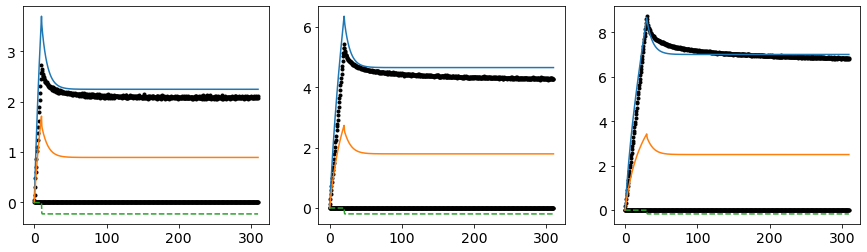

In [6]:
fig, ax = plt.subplots(1,3,figsize=[15,4])
for i in range(3):
    sigm_pr, lm1, lm2, lm3, lm1e, lm2e, lm3e = biaxial_relax(gov_params, gov_norm, False, time[i], lmb_x[i], lmb_y[i])

    ax[i].plot(time[0],sgm_x[i],'k.')
    ax[i].plot(time[0],sgm_y[i],'k.')
    ax[i].plot(time[0],sigm_pr[:,0,0])
    ax[i].plot(time[0],sigm_pr[:,1,1])
    ax[i].plot(time[0],sigm_pr[:,2,2], '--')

# 2. Train $\Psi_{EQ}$ and $\Psi_{NEQ}$

In [7]:
with open('saved/bc_VTT_gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)
gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = gov_params

In [8]:
# Stuff common to both Psi_EQ and Psi_NEQ
layers = [1, 5, 5, 1]
def loss(params, lmb, sigma_gt):
    lm1 = lmb[:,0]
    lm2 = lmb[:,1]
    lm3 = lmb[:,2]
    sigma_pr = sigma_split_vmap(lm1, lm2, lm3, params)
    loss1 = np.average((sigma_pr[:,0,0]-sigma_gt[:,0,0])**2) 
    loss2 = np.average((sigma_pr[:,1,1]-sigma_gt[:,1,1])**2)
    loss3 = np.average((sigma_pr[:,2,2]-sigma_gt[:,2,2])**2)
    loss = (loss1+loss2+loss3)/3
    return  loss
    
@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, Y, opt_state, key, nIter = 10000, batch_size = 10):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False)
        opt_state = step(loss, it, opt_state, X[idx_batch], Y[idx_batch])         
        if it%10000 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

# Generate inputs
lm = np.linspace(0.7,1.4,20)
lm1, lm2 = np.array(np.meshgrid(lm, lm))
lm1 = lm1.reshape(-1)
lm2 = lm2.reshape(-1)
lm3 = 1/(lm1*lm2)
lmb_1 = np.transpose(np.array([lm1, lm2, lm3]))
lmb_2 = np.transpose(np.array([lm1, lm2, lm3*0.95]))
lmb = np.vstack([lmb_1, lmb_2])

## 2.1 $\Psi_{EQ}$

In [9]:
# Initialize parameters
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
Psi_eq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias)

# Generate outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],gov_Psi_eq_params)

# Train
opt_init, opt_update, get_params = optimizers.adam(1.e-5)
opt_state = opt_init(Psi_eq_params)
Psi_eq_params, train_loss, val_loss = train(loss, lmb, sigma_gt, opt_state, key, nIter = 200000, batch_size = 10)
with open('saved/bc_VTT_Psi_eq_params.npy', 'wb') as f:
    pickle.dump(Psi_eq_params, f)

it 0, train loss = 2.361910e+05
it 10000, train loss = 2.360344e+05
it 20000, train loss = 2.360320e+05
it 30000, train loss = 2.360320e+05
it 40000, train loss = 2.360319e+05
it 50000, train loss = 2.360319e+05
it 60000, train loss = 2.360319e+05
it 70000, train loss = 2.360319e+05
it 80000, train loss = 2.360319e+05
it 90000, train loss = 2.360319e+05
it 100000, train loss = 2.360319e+05
it 110000, train loss = 2.360319e+05
it 120000, train loss = 2.360319e+05
it 130000, train loss = 2.360319e+05
it 140000, train loss = 2.360319e+05
it 150000, train loss = 2.360319e+05
it 160000, train loss = 2.360319e+05
it 170000, train loss = 2.360319e+05
it 180000, train loss = 2.360319e+05
it 190000, train loss = 2.360319e+05
it 200000, train loss = 2.360319e+05


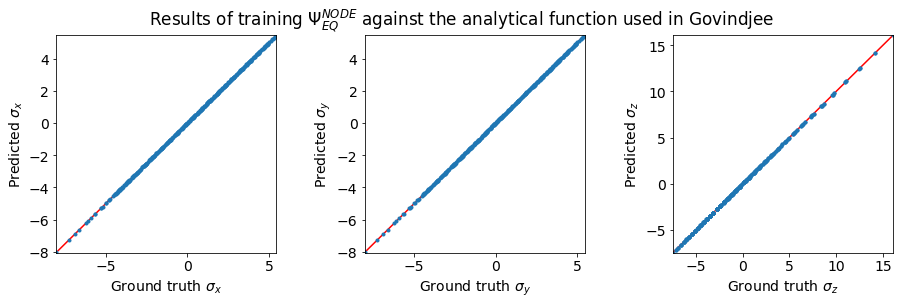

In [10]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_eq_params)
sigma_gt = sigma_neoHook_vmap(lm1, lm2, lm3, gov_Psi_eq_params) #since I am using the same MM for both EQ and NEQ
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{EQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

## 2.2 $\Psi_{NEQ}$

In [11]:
# Initialize parameters
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
Psi_neq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias)

# Generate outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],gov_Psi_neq_params)

opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Psi_neq_params)
Psi_neq_params, train_loss, val_loss = train(loss, lmb, sigma_gt, opt_state, key, nIter = 100000, batch_size = 10)
with open('saved/bc_VTT_Psi_neq_params.npy', 'wb') as f:
    pickle.dump(Psi_neq_params, f)

it 0, train loss = 2.004241e+05
it 10000, train loss = 2.002647e+05
it 20000, train loss = 2.002623e+05
it 30000, train loss = 2.002622e+05
it 40000, train loss = 2.002622e+05
it 50000, train loss = 2.002622e+05
it 60000, train loss = 2.002622e+05
it 70000, train loss = 2.002622e+05
it 80000, train loss = 2.002622e+05
it 90000, train loss = 2.002622e+05
it 100000, train loss = 2.002622e+05


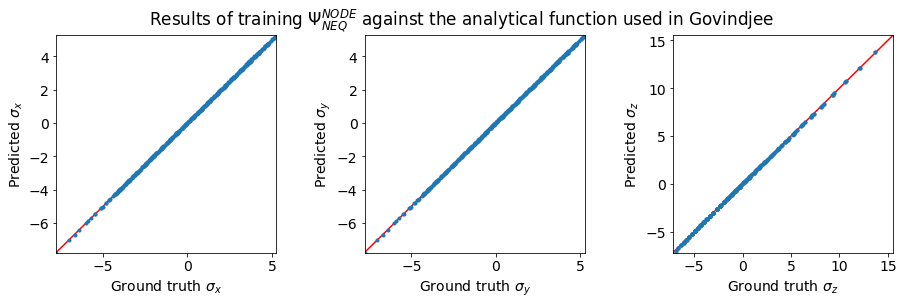

In [12]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_neq_params)
# sigma_gt = sigma_Ogden_vmap(lm1, lm2, lm3, gov_Psi_neq_params)
sigma_gt = sigma_neoHook_vmap(lm1, lm2, lm3, gov_Psi_neq_params)
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{NEQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

# 3. Train $\Phi^{NODE}$ with $\Phi^{Govindjee}$

In [13]:
with open('saved/bc_VTT_gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)
gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = gov_params
eta_D, eta_V = gov_Phi_params

In [14]:
# Generate training data
# Input data and normalization factors
taui = onp.mgrid[-200:200:10j, -200:200:10j, -200:200:10j]
taui = taui.reshape([3,-1]).transpose()
taui = -onp.sort(-taui)

tau1 = taui[:,0]
tau2 = taui[:,1]
tau3 = taui[:,2]
I12     = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
I12m3I2 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

inp_std1 = onp.std(tau1)
inp_std2 = onp.std(tau1 + tau2)
inp_std3 = onp.std(tau1 + tau2 + tau3)
inp_std4 = onp.std(I12)
inp_std5 = onp.std(I12m3I2)
inp_stds = (inp_std3, inp_std4, inp_std5)

out_std1 = 1.0
out_std2 = 1.0
out_std3 = 1.0
out_std4 = 1/9/175000
out_std5 = 1/3/1360
out_stds = (out_std3, out_std4, out_std5)
Phi_norm = (inp_stds, out_stds)

# Output data
dphidtaui = onp.array(dPhi_gov_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)).transpose()

In [15]:
# Initialize NN weights
layers = [1,2,3,1]
NODE3_params = init_params_positivebias(layers, key)
NODE4_params = init_params_positivebias(layers, key)
NODE5_params = init_params_positivebias(layers, key)
Phi_params = [NODE3_params, NODE4_params, NODE5_params]

# Train
def loss(params, norm, taui, dphidtaui_gt):
    tau1, tau2, tau3 = taui.transpose()
    dphidtaui_pr = dPhi_vmap([tau1, tau2, tau3], params, norm)
    loss = np.average((dphidtaui_pr[0]-dphidtaui_gt[:,0])**2)
    loss+= np.average((dphidtaui_pr[1]-dphidtaui_gt[:,1])**2)
    loss+= np.average((dphidtaui_pr[2]-dphidtaui_gt[:,2])**2)
    return loss
@partial(jit, static_argnums=(0,1,))
def step(loss, norm, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, norm, X_batch, Y_batch)
    return opt_update(i, g, opt_state)
def train(loss, X, Y, norm, opt_state, key, nIter = 5000, batch_size = 100):
    global best_params
    train_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False)
        opt_state = step(loss, norm, it, opt_state, X[idx_batch], Y[idx_batch])
        if it % 10000 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = loss(params, norm, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss

opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Phi_params)
Phi_params, train_loss = train(loss, taui, dphidtaui, Phi_norm, opt_state, key, nIter=50000)

with open('saved/bc_VTT_Phi_params.npy', 'wb') as f:
    pickle.dump(Phi_params, f)
with open('saved/bc_VTT_Phi_norm_w.npy', 'wb') as f:
    pickle.dump((inp_stds, out_stds), f)

it 0, train loss = 1.776042e+01
it 10000, train loss = 6.068503e+00
it 20000, train loss = 1.823488e+00
it 30000, train loss = 1.731579e-02
it 40000, train loss = 1.722880e-02
it 50000, train loss = 1.721963e-02


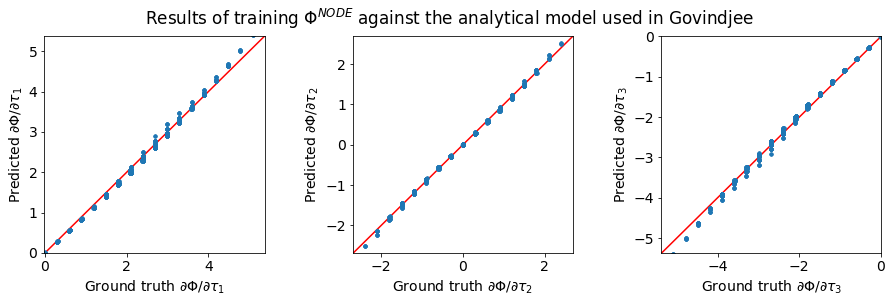

In [21]:
prs = dPhi_vmap([taui[:,0], taui[:,1], taui[:,2]], Phi_params, Phi_norm)
gts = dPhi_gov_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)

labels = ['$\partial \Phi / \partial \\tau_1$', '$\partial \Phi / \partial \\tau_2$', '$\partial \Phi / \partial \\tau_3$']
title = r"Results of training $\Phi^{NODE}$ against the analytical model used in Govindjee"
plot45(gts, prs, labels, title)

# 4. Test

In [21]:
#Load the pre-trained parameters
with open('saved/bc_VTT_Psi_eq_params.npy', 'rb') as f:
    Psi_eq_params = pickle.load(f)
with open('saved/bc_VTT_Psi_neq_params.npy', 'rb') as f:
    Psi_neq_params = pickle.load(f)
with open('saved/bc_VTT_Phi_params.npy', 'rb') as f:
    Phi_params = pickle.load(f)
with open('saved/bc_VTT_Phi_norm_w.npy', 'rb') as f:
    Phi_norm = pickle.load(f)
params = (Psi_eq_params, Psi_neq_params, Phi_params)
norm = (None, None, Phi_norm)

with open('saved/bc_VTT_gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)

with open('training_data/manu_bloodclots_short.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = pickle.load(f)

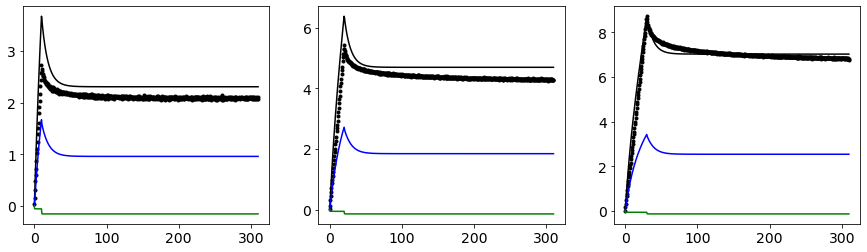

In [17]:
fig, ax = plt.subplots(1,3,figsize=(15,4))

for i in range(3):
    t = time[0]
    sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = biaxial_relax(params, norm, True, t, lmb_x[i],lmb_y[i])

    ax[i].plot(t, sgm_x[i], 'k.')
    ax[i].plot(t,sig_NN[:,0,0],'k-')
    ax[i].plot(t,sig_NN[:,1,1],'b-')
    ax[i].plot(t,sig_NN[:,2,2],'g-')

# 5. Retrain

In [ ]:
def loss(params, norm, useNODE, time, lm1, lm2, sigma1):
    sigma_pr,_,_,_,_,_,_ = biaxial_relax(params, norm, useNODE, time, lm1, lm2)
    loss = np.sqrt((sigma_pr[:,0,0]-sigma1[:])**2)
    return loss/lm1.shape[0]
loss_vmap = vmap(loss, in_axes=(None, None, None, 0, 0, 0, 0), out_axes=0)
batch_loss = lambda params, norm, useNODE, time, lm1, lm2, sigma1: np.mean(loss_vmap(params, norm, useNODE, time, lm1, lm2, sigma1))

@partial(jit, static_argnums=(0,1,2,))
def step(loss_fn, norm, useNODE, i, opt_state, X1_batch, X2_batch, X3_batch, Y1_batch):
    params = get_params(opt_state)
    g = grad(loss_fn, argnums=0)(params, norm, useNODE, X1_batch, X2_batch, X3_batch, Y1_batch)
    return opt_update(i, g, opt_state)

def train(X1, X2, X3, Y1, norm, opt_state, key, nIter = 1000, batch_size=10):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        i = random.choice(subkey, X1.shape[0], shape=(batch_size,), replace = False)
        i = tuple([i])
        opt_state = step(batch_loss, norm, True, it, opt_state, X1[i], X2[i], X3[i], Y1[i])
        if it % 100 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = batch_loss(params, norm, True, X1[i], X2[i], X3[i], Y1[i])
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss 

opt_init, opt_update, get_params = optimizers.adam(5.e-4)
opt_state = opt_init(params)

params, train_loss, val_loss = train(time[[1,2]], lmb_x[[1,2]], lmb_y[[1,2]], sgm_x[[1,2]], norm, opt_state, key, nIter = 1000, batch_size=2)
with open('saved/bc_VTT_params_retrained.npy', 'wb') as f:
    pickle.dump(params, f)

plt.plot(train_loss)

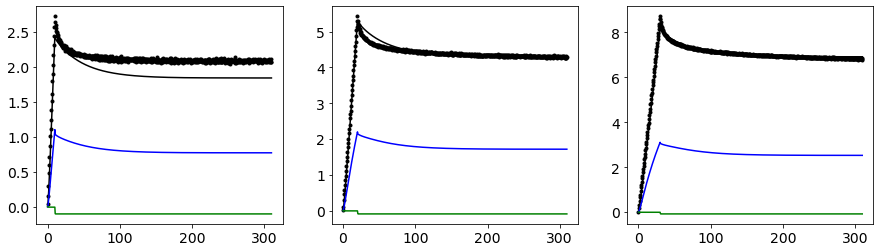

In [27]:
fig, ax = plt.subplots(1,3,figsize=(15,4))

for i in range(3):
    t = time[0]
    sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = biaxial_relax(params, norm, True, t, lmb_x[i],lmb_y[i])

    ax[i].plot(t, sgm_x[i], 'k.')
    ax[i].plot(t,sig_NN[:,0,0],'k-')
    ax[i].plot(t,sig_NN[:,1,1],'b-')
    ax[i].plot(t,sig_NN[:,2,2],'g-')

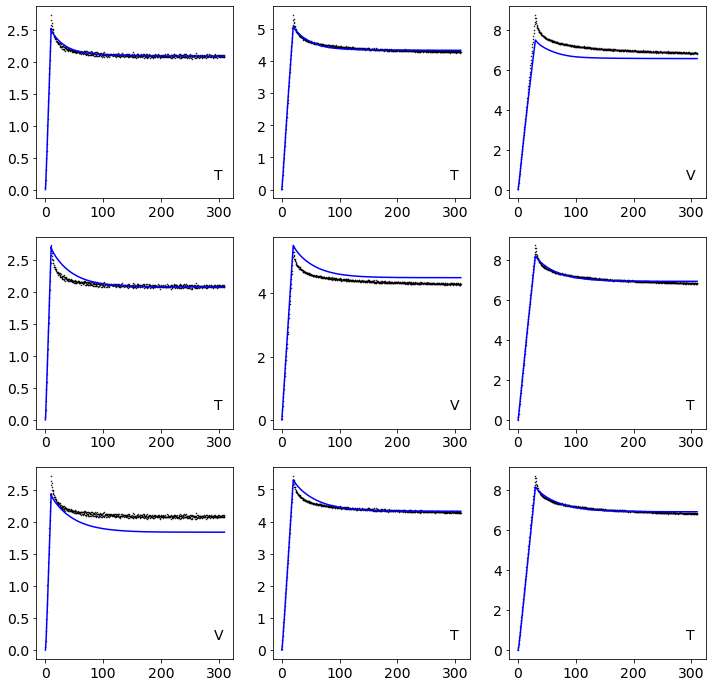

In [23]:
import pandas as pd
fig, ax = plt.subplots(3,3,figsize=(12,12))
labelset = ['abc', 'def', 'ghi']
cases = ['TTV', 'TVT', 'VTT']
t = time[0]
for label, case, axi in zip(labelset, cases, ax):
    with open('saved/bc_'+case+'_params_retrained.npy', 'rb') as f:
        params = pickle.load(f)
    with open('saved/bc_'+case+'_Phi_norm_w.npy', 'rb') as f:
        Phi_norm = pickle.load(f)
        norm = (None, None, Phi_norm)
    for i in range(3):
        sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = biaxial_relax(params, norm, True, t, lmb_x[i],lmb_y[i])
        axi[i].plot(t, sgm_x[i], 'k.', markersize=1)
        axi[i].plot(t,sig_NN[:,0,0],'b-')
        # axi[i].plot(t,sig_NN[:,1,1],'b-')
        # axi[i].plot(t,sig_NN[:,2,2],'g-')
        axi[i].text(0.9,0.1,case[i],transform=axi[i].transAxes)

        #Save to TikZ
        header = ['x', 'y_gt', 'y_pr']
        df = pd.DataFrame(np.array([t, sgm_x[i], sig_NN[:,0,0]]).T, columns=header)
        df.to_csv('tikz_data/fig_bc/fig_bc_'+label[i]+'.csv', index=False, sep=' ')

In [ ]:
# Another idea: Train with data upto t=100 and test with the rest.